# Analyse av anki-data
Gjort ved hjelp av python, uten bruk av pandas.

In [3]:
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pytz
import csv

In [4]:
with open("anki-reviews.csv") as file:
    data = csv.DictReader(file)
    reviews = list(data)
reviews[0]

{'id': '1645550962771',
 'cid': '1645550870303',
 'usn': '0',
 'ease': '3',
 'ivl': '-600',
 'lastIvl': '-60',
 'factor': '0',
 'time': '15705',
 'type': '0'}

In [5]:
# Find only the last review of each card
cards = {}
for r in reviews:
    cards[r["cid"]] = r
cards = list(cards.values())

In [23]:
timezone = pytz.timezone("Europe/Oslo")
dates = [
    datetime.fromtimestamp(int(r["id"]) / 1000, tz=pytz.UTC).astimezone(timezone)
    for r in reviews
]

Text(0.5, 1.0, 'Review distribution over time')

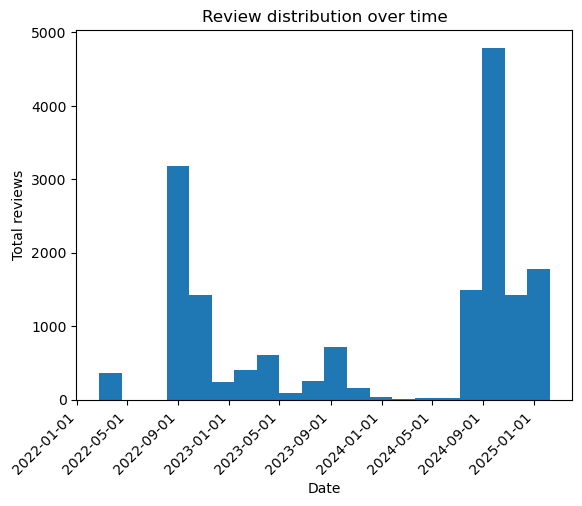

In [83]:
fig, ax = plt.subplots()
ax.hist(dates, bins=20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Date")
ax.set_ylabel("Total reviews")
ax.set_title("Review distribution over time")

Text(0.5, 1.0, 'Card type distribution')

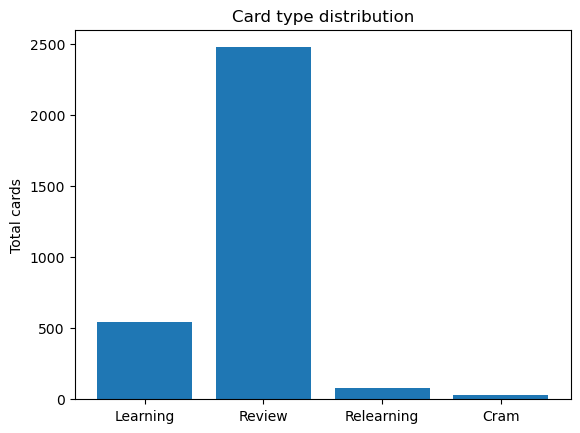

In [16]:
card_types = defaultdict(int)
for c in cards:
    card_types[c["type"]] += 1
card_types = sorted(card_types.items(), key=lambda c: c[0])

fig, ax = plt.subplots()
ax.bar(*zip(*card_types))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["Learning", "Review", "Relearning", "Cram"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Total cards")
ax.set_title("Card type distribution")

Text(0.5, 1.0, 'Review ease distribution')

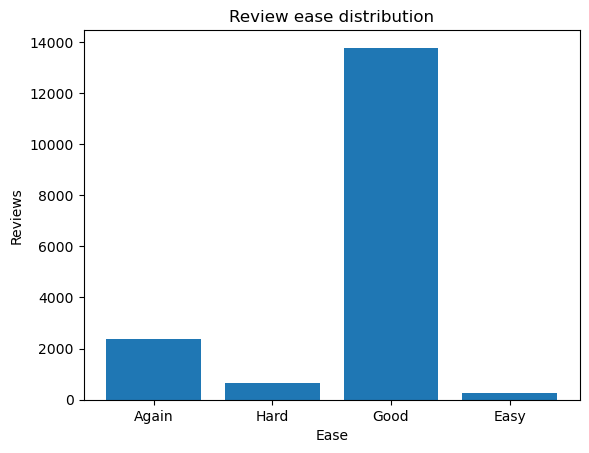

In [17]:
eases = defaultdict(int)
for r in reviews:
    eases[r["ease"]] += 1
eases = sorted(eases.items(), key=lambda e: e[0])

fig, ax = plt.subplots()
ax.bar(*zip(*eases))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["Again", "Hard", "Good", "Easy"], rotation=0)
ax.set_xlabel("Ease")
ax.set_ylabel("Reviews")
ax.set_title("Review ease distribution")

Text(0.5, 1.0, 'Review ease distribution')

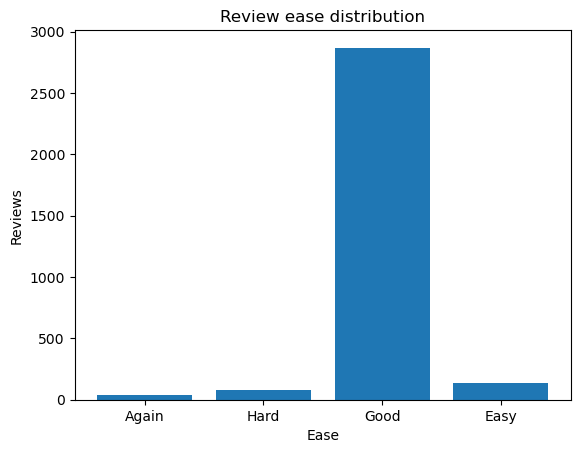

In [18]:
eases = defaultdict(int)
for r in cards:
    eases[r["ease"]] += 1
eases = sorted(eases.items(), key=lambda e: e[0])

fig, ax = plt.subplots()
ax.bar(*zip(*eases))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["Again", "Hard", "Good", "Easy"], rotation=0)
ax.set_xlabel("Ease")
ax.set_ylabel("Reviews")
ax.set_title("Review ease distribution")

Text(0.5, 1.0, 'Card interval distribution')

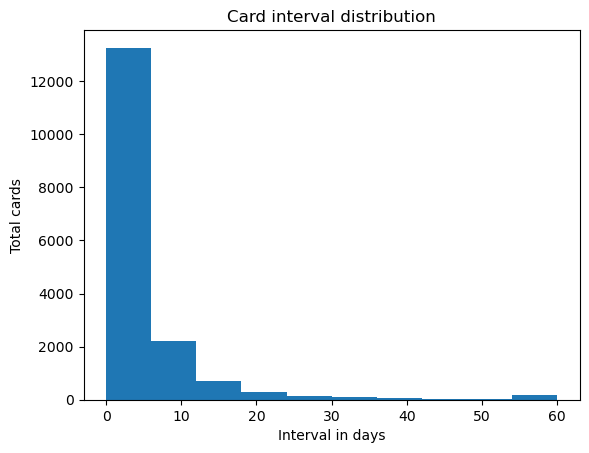

In [5]:
# Could just directly / 1000 instead of going through timedelta
times = [timedelta(milliseconds=int(r["time"])).total_seconds() for r in reviews]

fig, ax = plt.subplots()
ax.hist(times)
ax.set_xlabel("Interval in days")
ax.set_ylabel("Total cards")
ax.set_title("Card interval distribution")

Text(0.5, 1.0, 'Card interval distribution')

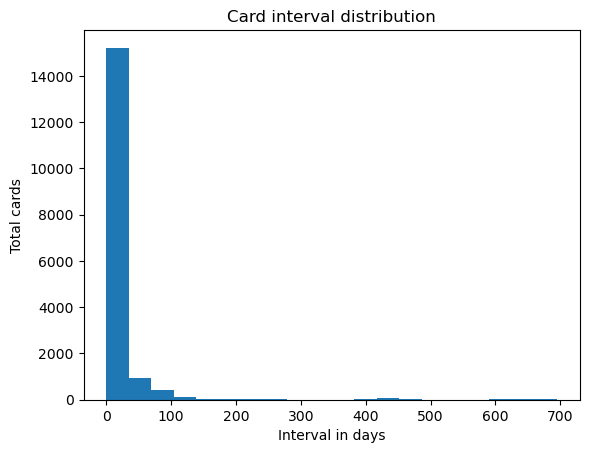

In [79]:
def parse_ivl(ivl):
    return timedelta(days=ivl) if ivl > 0 else timedelta(seconds=-ivl)
intervals = [parse_ivl(int(r["ivl"])).total_seconds() / 86400 for r in reviews]

fig, ax = plt.subplots()
ax.hist(intervals, bins=20)
ax.set_xlabel("Interval in days")
ax.set_ylabel("Total cards")
ax.set_title("Card interval distribution")

Text(0.5, 1.0, 'Reviews by weekday')

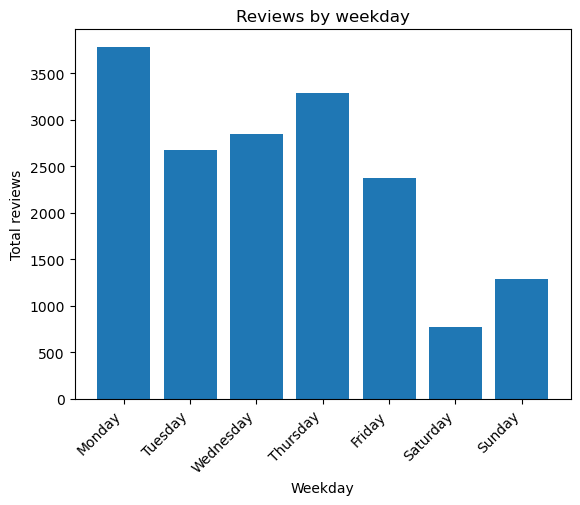

In [25]:
weekdays = defaultdict(int)
for d in dates:
    weekdays[d.weekday()] += 1
weekdays = sorted(weekdays.items(), key=lambda d: d[0])

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, ax = plt.subplots()
ax.bar(days, [d[1] for d in weekdays])
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Weekday")
ax.set_ylabel("Total reviews")
ax.set_title("Reviews by weekday")

Text(0.5, 1.0, 'Reviews by time of day')

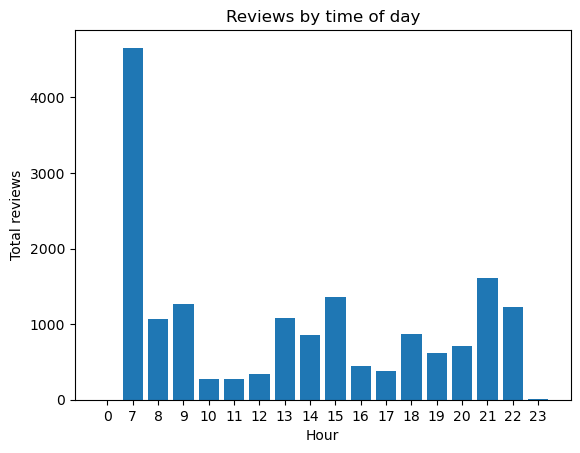

In [34]:
hours = {}
for d in dates:
    hour = str(d.hour) # So that spacing is not unnecessarily added where there is no value
    hours[hour] = hours.get(hour, 0) + 1
hours = sorted(hours.items(), key=lambda h: int(h[0]))

fig, ax = plt.subplots()
ax.bar(*zip(*hours))
ax.set_xlabel("Hour")
ax.set_ylabel("Total reviews")
ax.set_title("Reviews by time of day")

Text(0, 0.5, 'Average efficiency (ease / time)')

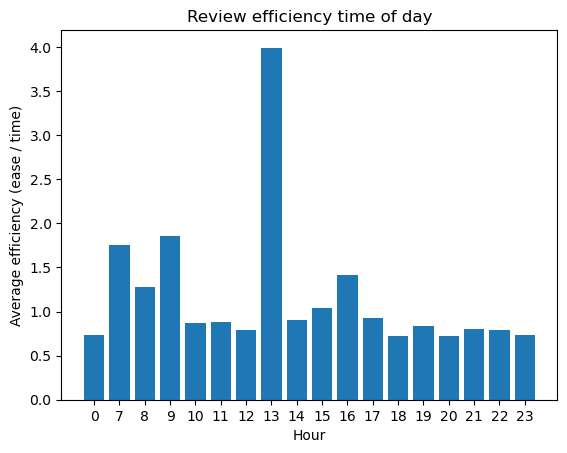

In [8]:
efficiencies = [
    (datetime.fromtimestamp(int(r["id"]) / 1000, tz=pytz.UTC).astimezone(
        pytz.timezone("Europe/Oslo")
    ), float(r["ease"]) / (float(r["time"]) / 1000)) # ease / time in seconds
    for r in reviews
]

efficiency_by_hour = defaultdict(list)
for (date, efficiency) in efficiencies:
    hour = str(date.hour) # Same as earlier; to avoid gaps
    efficiency_by_hour[hour].append(efficiency)

efficiency_by_hour = {hour: sum(efficiencies) / len(efficiencies) for hour, efficiencies in efficiency_by_hour.items()}
efficiency_by_hour = sorted(efficiency_by_hour.items(), key=lambda e: int(e[0]))

fig, ax = plt.subplots()
ax.bar(*zip(*efficiency_by_hour))
ax.set_title("Review efficiency time of day")
ax.set_xlabel("Hour")
ax.set_ylabel("Average efficiency (ease / time)")

Text(0, 0.5, 'Efficiency')

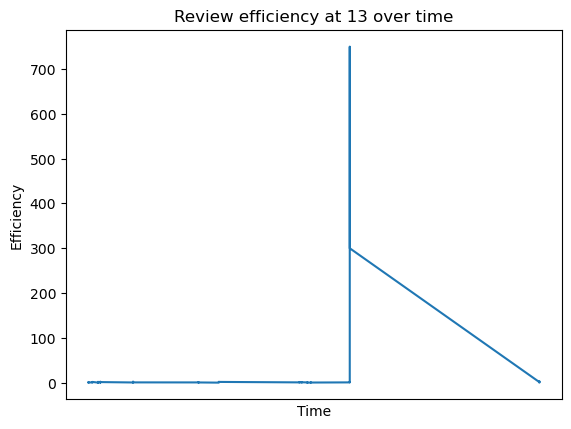

In [27]:
reviews_at_13 = [e for e in efficiencies if e[0].hour == 13]

fig, ax = plt.subplots()
ax.plot(*zip(*reviews_at_13))
ax.set_title("Review efficiency at 13 over time")
ax.set_xticks([])
ax.set_xlabel("Time")
ax.set_ylabel("Efficiency")

In [10]:
len(reviews_at_13)

1087

Text(0, 0.5, 'Efficiency')

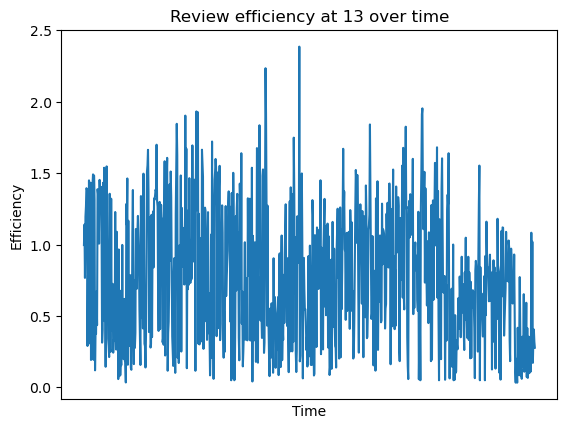

In [28]:
before_outlier = [e for e in reviews_at_13 if e[0] < timezone.localize(datetime(2023, 11, 1))]

dates, effs = zip(*before_outlier)
xs = range(len(dates))

fig, ax = plt.subplots()
ax.plot(xs, effs)
ax.set_title("Review efficiency at 13 over time")
ax.set_xticks([])
ax.set_xlabel("Time")
ax.set_ylabel("Efficiency")